### Example of usage of ZTMParser

In [50]:
from ztm import *

import re
import time
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx

In [4]:
reader = ZTMTagReader("../project/data/P8/RA231125.TXT")

In [5]:
data = {}
data["ZP"] = reader.read("ZP")
data["PR"] = reader.read("PR")
data["WK"] = reader.read("WK")

In [6]:
parsed_data = {}
for tag_key in data:
    parser = ZTMParser(tag=tag_key)(data[tag_key])
    parsed_data[tag_key] = parser()

In [8]:
parsed_data["ZP"][0]

{'group_id': 1001,
 'group_name': 'Kijowska',
 'city_symbol': '--',
 'city_name': 'WARSZAWA'}

In [10]:
parsed_data["PR"][0]

{'id': 100101,
 'group_id': 1001,
 'station_id': 1,
 'source': 'Targowa',
 'target': 'al.Zieleniecka',
 'longitude': '52.248455',
 'latitude': '21.044827',
 'pu': 0,
 'number_of_lines': 9,
 'stop_type': 'stały',
 'lines_list': ['102', '123', '125', '138', '146', '147', '166', '202', '509']}

In [7]:
parsed_data["WK"][0]

{'course_id': 'TD-1AN04/DS/07.31',
 'stop_id': '500403',
 'day_type': 'DS',
 'time': '7.32',
 'extra': None}

In [11]:
df_groups = pd.DataFrame(
    parsed_data["ZP"],
)

df_courses = pd.DataFrame(
    parsed_data["PR"],
)

In [12]:
df_groups.head()

,group_id,group_name,city_symbol,city_name
0,1001,Kijowska,--,WARSZAWA
1,1002,Ząbkowska,--,WARSZAWA
2,1003,Dw.Wileński,--,WARSZAWA
3,1004,Ratuszowa-ZOO,--,WARSZAWA
4,1005,pl.Hallera,--,WARSZAWA


In [13]:
df_courses.head()

,id,group_id,station_id,source,target,longitude,latitude,pu,number_of_lines,stop_type,lines_list
0,100101,1001,1,Targowa,al.Zieleniecka,52.248455,21.044827,0.0,9,stały,"[102, 123, 125, 138, 146, 147, 166, 202, 509]"
1,100101,1001,1,Targowa,al.Zieleniecka,52.248455,21.044827,0.0,4,na żądanie,"[N02, N03, N21, N71]"
2,100102,1001,2,Targowa,Ząbkowska,52.249078,21.044443,0.0,3,stały,"[138, 166, 509]"
3,100102,1001,2,Targowa,Ząbkowska,52.249078,21.044443,0.0,1,na żądanie,[N21]
4,100102,1001,2,Targowa,Ząbkowska,52.249078,21.044443,0.0,1,dla wsiadających,[509^]


In [24]:
def define_vehicle_type(code: str) -> str:
    out = "unknown"
    if re.match(r"^(\d{3,}|[ECNLZ]A?-?\d+)\^?$", code):
        # 101-399 - normal course
        # 300-399 - normal course (only at specific times)
        # 400-599 - accelerated bus lines
        # 700-899 - zone bus lines
        # E-<number> - express bus lines
        # L<number> - local bus lines
        # 900-999, C<number> - special bus lines
        # N<number> - night bus lines
        # L<number> - local bus lines
        # Z(A?)-<number> - bus replacement for tram in case of works/emergency
        out = "bus"
    if re.match(r"^S-?\d+\^?$", code):
        out = "skm"
    if re.match(r"^\d{1,2}\^?$", code):
        # 1-79 - tram lines
        # 1-39 - normal tram lines
        # 40-49 - tram lines only at specific times
        # 50-79 - special or replacement tram lines
        out = "tram"
    return out

In [25]:
def calculate_vehicle_type(row):
    def extract_vehicle_type(vehice_type: str) -> bool:
        return (
            row[["lines_list"]]
            .explode("lines_list")
            .apply(lambda x: define_vehicle_type(x))
            == vehice_type
        ).all()

    if extract_vehicle_type("bus"):
        return "bus"
    if extract_vehicle_type("tram"):
        return "tram"
    if extract_vehicle_type("skm"):
        return "skm"
    return "unknown"

In [26]:
df_courses["vehicle_type"] = df_courses.apply(calculate_vehicle_type, axis=1)

In [27]:
df_courses.vehicle_type.value_counts()

vehicle_type
bus        8076
tram        581
skm         129
unknown       9
Name: count, dtype: int64

In [28]:
df_merged = pd.merge(df_groups, df_courses, on="group_id", how="left")

In [29]:
df_merged.head()

,group_id,group_name,city_symbol,city_name,id,station_id,source,target,longitude,latitude,pu,number_of_lines,stop_type,lines_list,vehicle_type
0,1001,Kijowska,--,WARSZAWA,100101,1,Targowa,al.Zieleniecka,52.248455,21.044827,0.0,9,stały,"[102, 123, 125, 138, 146, 147, 166, 202, 509]",bus
1,1001,Kijowska,--,WARSZAWA,100101,1,Targowa,al.Zieleniecka,52.248455,21.044827,0.0,4,na żądanie,"[N02, N03, N21, N71]",bus
2,1001,Kijowska,--,WARSZAWA,100102,2,Targowa,Ząbkowska,52.249078,21.044443,0.0,3,stały,"[138, 166, 509]",bus
3,1001,Kijowska,--,WARSZAWA,100102,2,Targowa,Ząbkowska,52.249078,21.044443,0.0,1,na żądanie,[N21],bus
4,1001,Kijowska,--,WARSZAWA,100102,2,Targowa,Ząbkowska,52.249078,21.044443,0.0,1,dla wsiadających,[509^],bus


In [38]:
df_nodes = df_merged.groupby("group_id").agg(
    {
        "group_name": "first",
        "city_symbol": "first",
        "city_name": "first",
        "longitude": "first",
        "latitude": "first",
        "number_of_lines": "sum",
        "vehicle_type": "first",
    }
)

In [39]:
df_nodes.head()

,group_name,city_symbol,city_name,longitude,latitude,number_of_lines,vehicle_type
group_id,,,,,,,
1001,Kijowska,--,WARSZAWA,52.248455,21.044827,65,bus
1002,Ząbkowska,--,WARSZAWA,52.251325,21.038457,41,bus
1003,Dw.Wileński,--,WARSZAWA,52.253739,21.035454,82,bus
1004,Ratuszowa-ZOO,--,WARSZAWA,52.256614,21.028536,6,tram
1005,pl.Hallera,--,WARSZAWA,52.258094,21.027097,41,bus


In [30]:
def handle_time(time):
    h = int(time.split(".")[0])
    m = time.split(".")[1]
    if h > 23:
        time = str(h - 24) + "." + m
    return time


def calculate_time_diff(time1, time2):
    time1 = handle_time(time1)
    time2 = handle_time(time2)
    t1 = time.mktime(time.strptime(time1, "%H.%M"))
    t2 = time.mktime(time.strptime(time2, "%H.%M"))
    if t2 < t1:
        t2 += 24 * 60 * 60
    return (t2 - t1) / 60

In [31]:
def generate_edges(
    data: list[dict[str, Any]], vehicle_lookup: pd.DataFrame
) -> list[dict[str, Any]]:
    edges = []
    initial = None
    lookup_dict = {}
    for item in data:
        if initial == None:
            initial = item
            source = int(item["stop_id"][:4])
            source_time = item["time"]
            continue
        target = int(item["stop_id"][:4])
        target_time = item["time"]
        time_diff = calculate_time_diff(source_time, target_time)

        vehicle_type = lookup_dict.get(int(item["stop_id"]))
        if vehicle_type == None:
            vehicle_type = vehicle_lookup[vehicle_lookup["id"] == int(item["stop_id"])][
                "vehicle_type"
            ].values[0]
            lookup_dict[int(item["stop_id"])] = vehicle_type
        try:
            edges.append(
                {
                    "source": source,
                    "target": target,
                    "time_from": source_time,
                    "time_to": target_time,
                    "length_min": time_diff,
                    "vehicle_type": vehicle_type,
                }
            )
        except IndexError as e:
            print(item)
            raise e

        if item.get("extras") == "P":
            # end of course
            initial = None
        source = target
        source_time = target_time
    return edges

In [32]:
edges = generate_edges(parsed_data["WK"], vehicle_lookup=df_courses)

In [33]:
df_edges = pd.DataFrame(edges)

In [34]:
df_edges.head()

,source,target,time_from,time_to,length_min,vehicle_type
0,5004,5003,7.32,7.35,3.0,tram
1,5003,5084,7.35,7.36,1.0,tram
2,5084,5085,7.36,7.37,1.0,tram
3,5085,5086,7.37,7.38,1.0,tram
4,5086,5087,7.38,7.39,1.0,tram


In [35]:
df_edges_uniq = df_edges.groupby(
    ["source", "target", "vehicle_type"], as_index=False
).agg(
    time_from=("time_from", "min"),
    time_to=("time_to", "max"),
    length_min=("length_min", "sum"),
    weight=("length_min", "count"),
)
df_edges_uniq = df_edges_uniq[
    df_edges_uniq["source"] != df_edges_uniq["target"]
].set_index(["source", "target"])

In [40]:
def pandas_to_nx(df, index_keys: list[str] | None = None):
    if index_keys is not None:
        return list(
            zip(
                df.index.get_level_values("source"),
                df.index.get_level_values("target"),
                df.to_dict(orient="records"),
            )
        )
    return list(zip(df.index, df.to_dict("records")))

In [41]:
edges = pandas_to_nx(df_edges_uniq, index_keys=["source", "target"])

In [42]:
nodes = pandas_to_nx(df_nodes)

In [44]:
G = nx.MultiDiGraph()
G.add_edges_from(edges)
G.add_nodes_from(nodes)

In [45]:
# map vehicle_type to different colors
vehicle_type = df_nodes.vehicle_type.unique()
vehicle_colors = {}
colors = [
    "#5f1401",
    "#0f4c81",
    "#0f8114",
    "#4f4f0f",
]

for i, vehicle in enumerate(vehicle_type):
    vehicle_colors[vehicle] = colors[i % len(colors)]

node_colors = [vehicle_colors[node[1]["vehicle_type"]] for node in nodes]
edges = nx.get_edge_attributes(G, "vehicle_type").values()

edge_colors = [vehicle_colors[vehicle] for vehicle in edges]

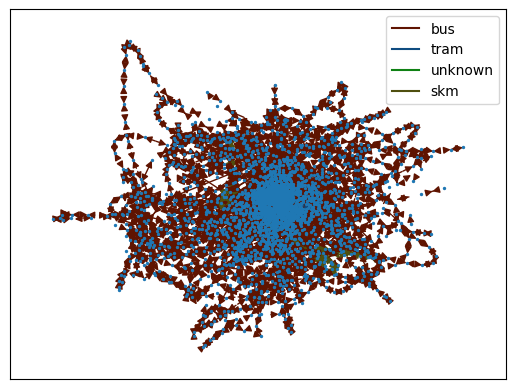

In [49]:
pos = nx.spring_layout(G, k=0.1, iterations=100)
nx.draw_networkx_nodes(G, pos, node_size=2)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors)

legend_elements = [
    Line2D(
        [0],
        [0],
        color=color,
        label=vehicle,
        markersize=3,
    )
    for vehicle, color in vehicle_colors.items()
]

plt.legend(handles=legend_elements, loc="upper right")
plt.show()